In [1]:
from fastai import *
from fastai.vision import *
import torch.onnx
from torch.autograd import Variable
import os
import cv2
from torch.optim import *
from fastai.callbacks import *

os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

In [2]:
path = Path("/media/subhaditya/DATA/COSMO/Datasets/emotionMask")

In [51]:
def show_2D_act(hook, l=0, nrows=3, ncols=9, s=12):
    """Show nrows*ncols activation visualizations of the l-th layer with figsize s*s"""
    fig, axes = plt.subplots(nrows, ncols, figsize=(s, s / 3))
    fig.subplots_adjust(hspace=0.1, wspace=0, left=0, right=1, top=1, bottom=0)
    for i, ax in enumerate(axes.flat):
        ax.imshow(custom_hook.stored[l][0][i].cpu(), cmap="magma")
        ax.set_axis_off()


# %debug
def create_layer_vis(x, img_path):
    layers = flatten_model(x)
    print(len(layers))
    custom_hook = hook_outputs(layers)

    learn.model.eval()
    img = open_image(img_path)
    learn.predict(img)
    [custom_hook.stored[i].shape for i in range(len(custom_hook.stored))]

    stored_hooks_rank = [
        len(custom_hook.stored[i].shape) for i in range(len(custom_hook.stored))
    ]
    min_rank = min(
        [len(custom_hook.stored[i].shape) for i in range(len(custom_hook.stored))]
    )

    for i in range(0, len(layers), 10):
        show_2D_act(custom_hook, i)

In [25]:
data = (
    (
        ImageList.from_folder(path)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(get_transforms(max_warp=0.0), size=64)
    )
    .databunch(bs=64)
    .normalize(imagenet_stats)
)

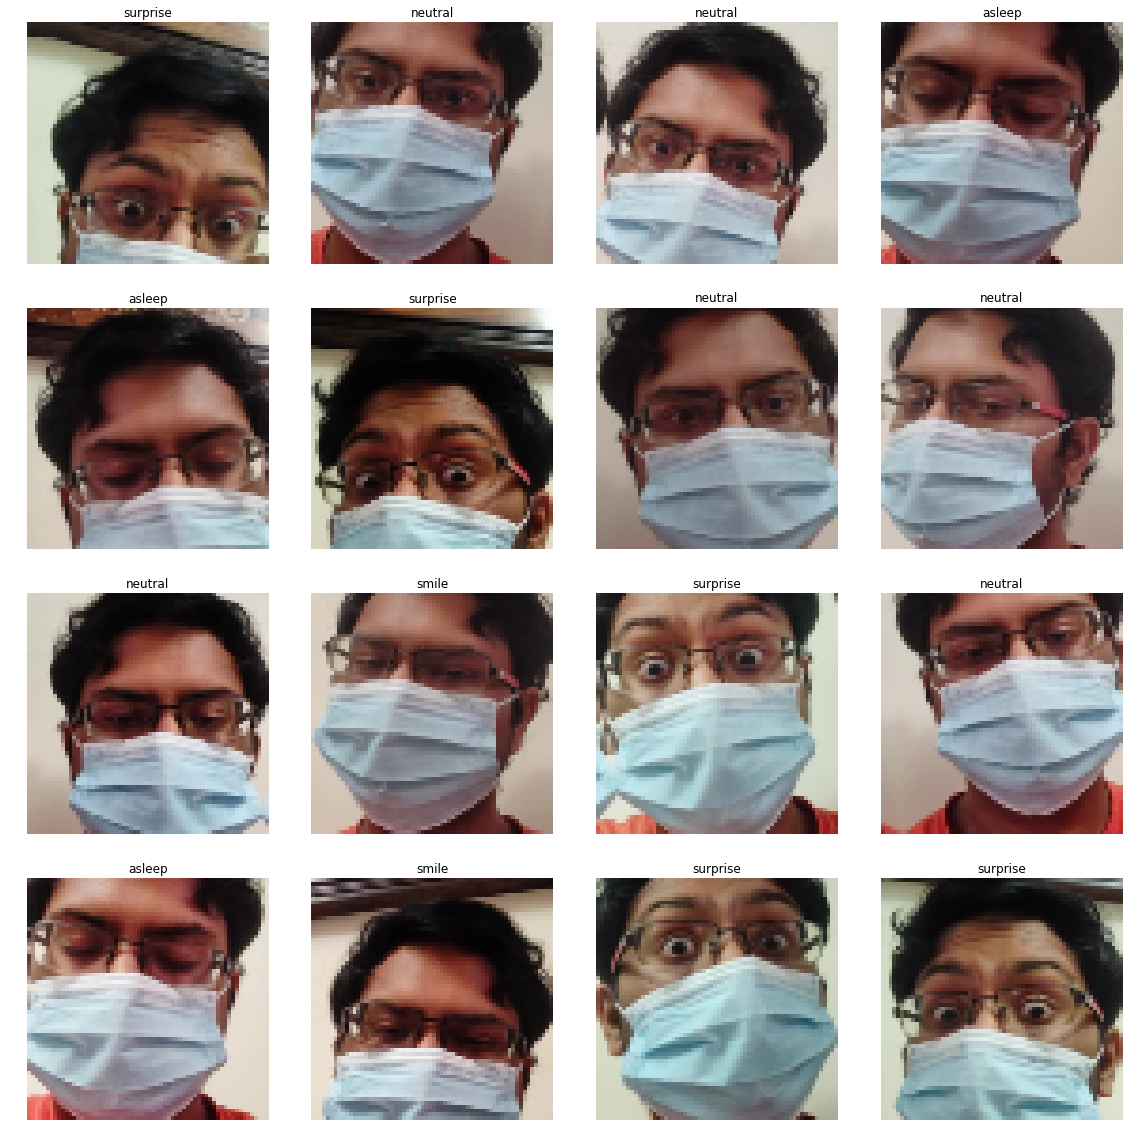

In [26]:
data.show_batch(4)

In [5]:
data.c

5

In [6]:
learn = None
gc.collect()

31387

In [27]:
learn = cnn_learner(
    data, models.resnet34, metrics=[accuracy], opt_func=AdamW, callback_fns=ShowGraph
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


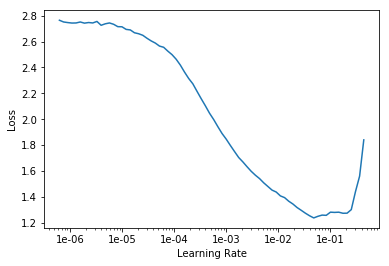

In [29]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,2.185251,2.378509,0.387387,00:06
1,1.438927,0.454172,0.837838,00:06
2,1.000711,0.064480,0.972973,00:06
3,0.831159,0.793106,0.945946,00:06
4,0.750457,0.100545,0.981982,00:06
5,0.617403,0.316353,0.981982,00:06
6,0.531501,0.000255,1.000000,00:06
7,0.450831,0.000147,1.000000,00:06
8,0.379217,0.001055,1.000000,00:06
9,0.320607,0.013517,0.990991,00:06


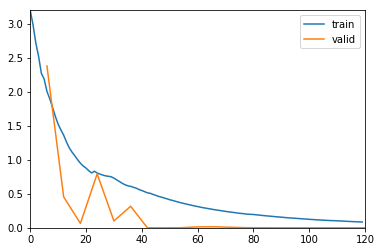

In [30]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(3e-4, 1e-2), wd=1e-3)

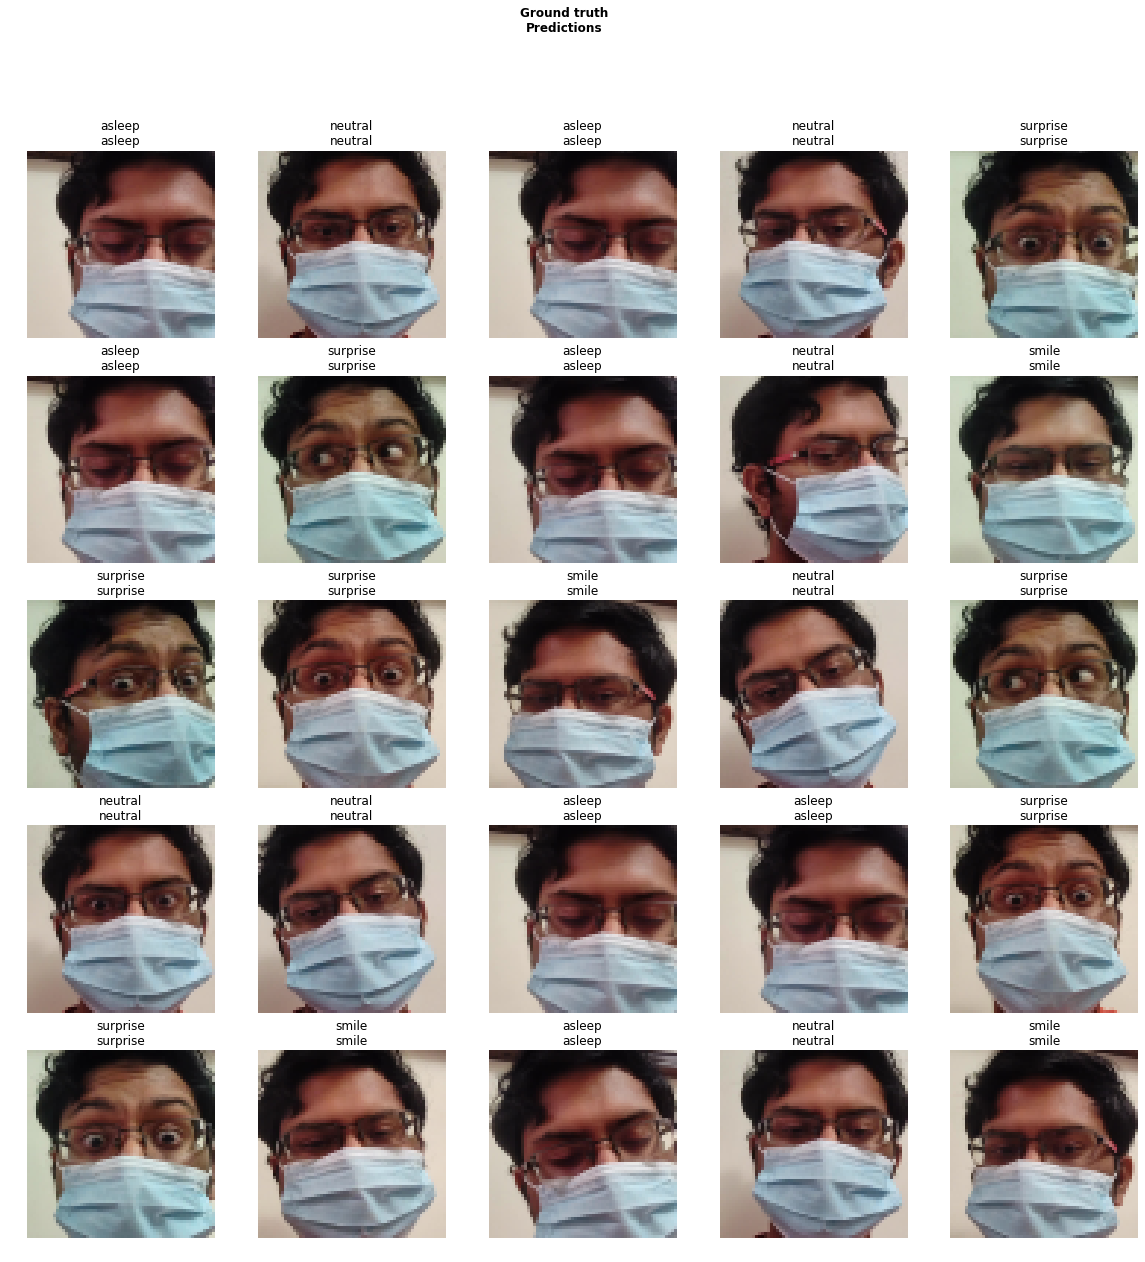

In [31]:
learn.show_results(ds_type=DatasetType.Valid)

In [34]:
learn.data.y.classes

['asleep', 'neutral', 'smile', 'surprise', 'test']

100


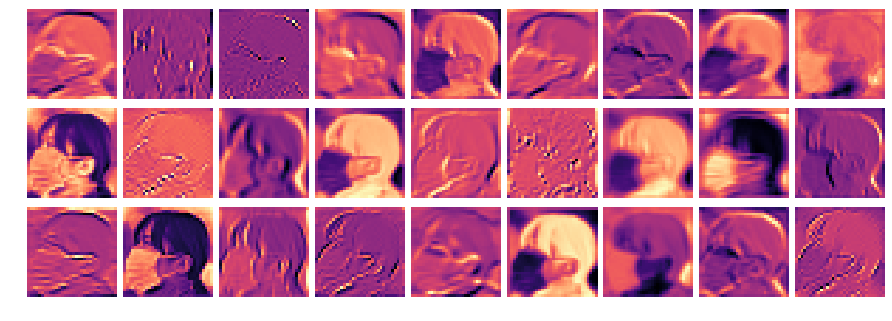

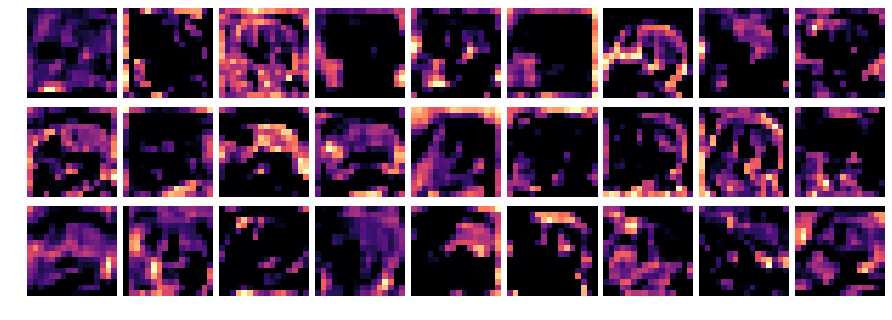

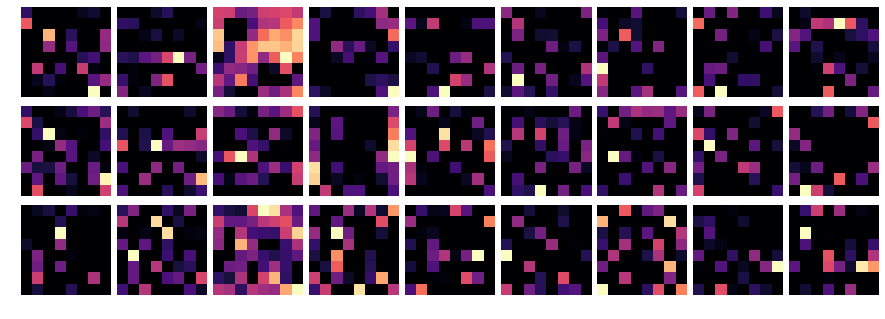

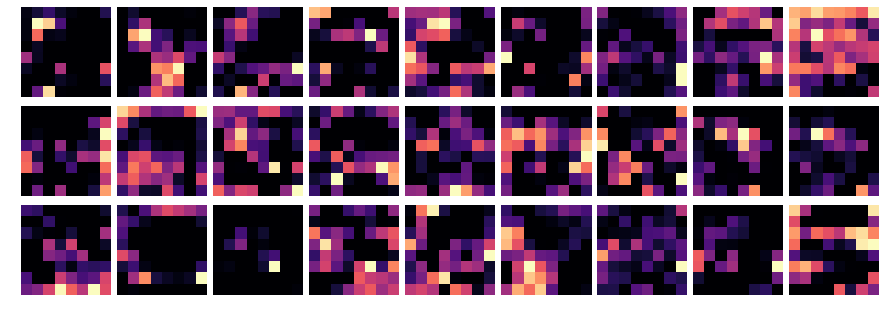

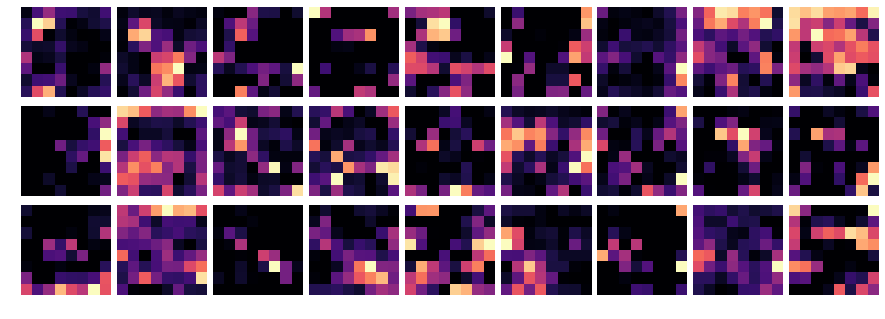

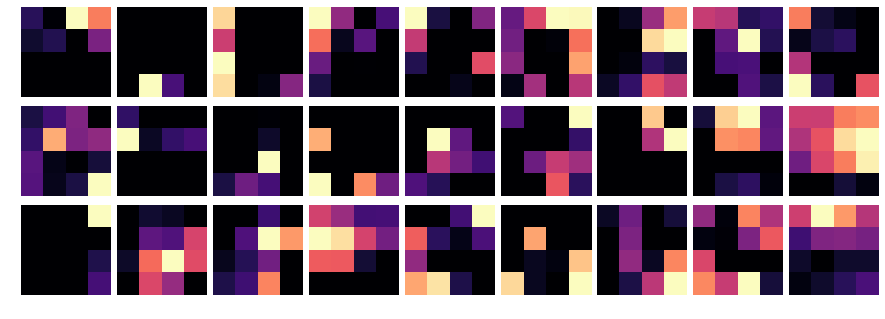

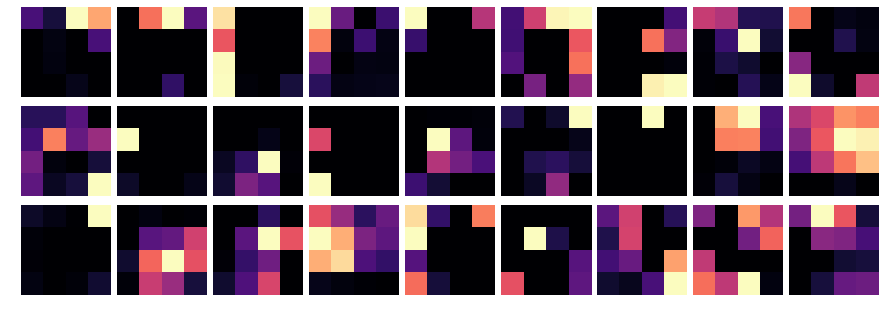

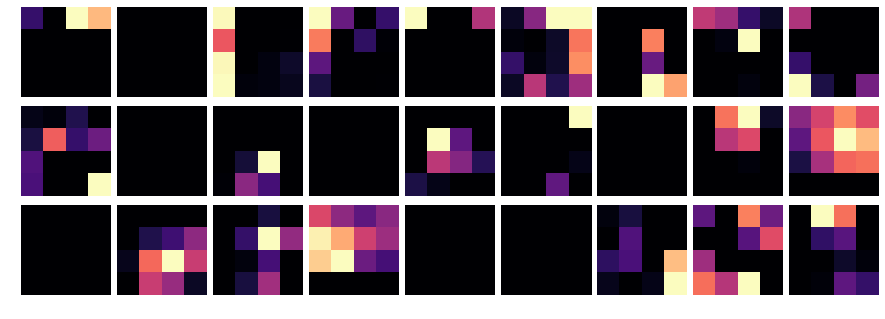

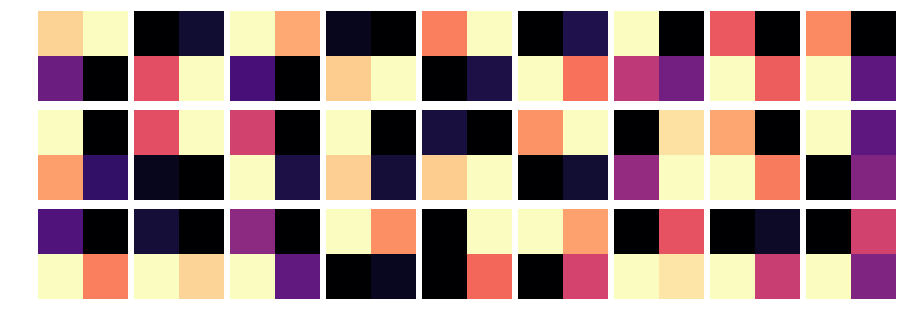

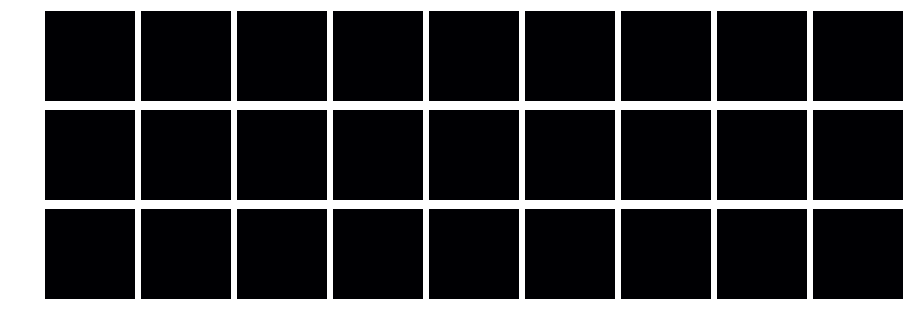

In [52]:
create_layer_vis(
    learn.model, path / "test/img1.jpg",
)

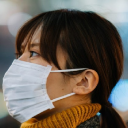

In [29]:
open_image(path / "test/img1.jpg").resize(128)

In [25]:
str(learn.predict(open_image(path / "test/img1.jpg"))[0])

'neutral'

100


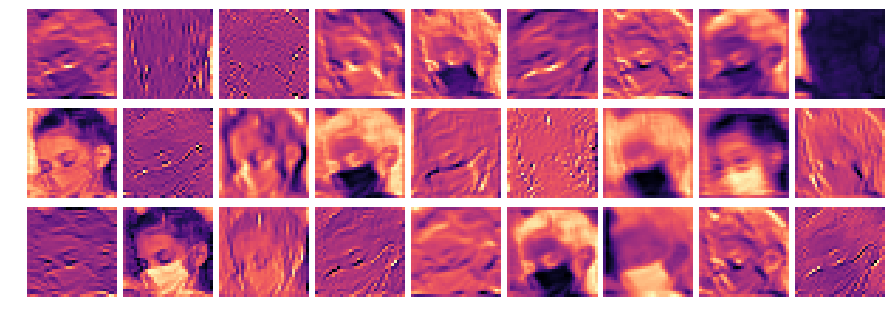

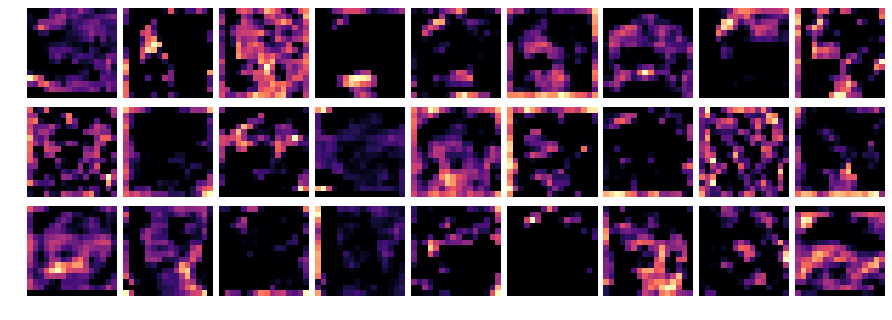

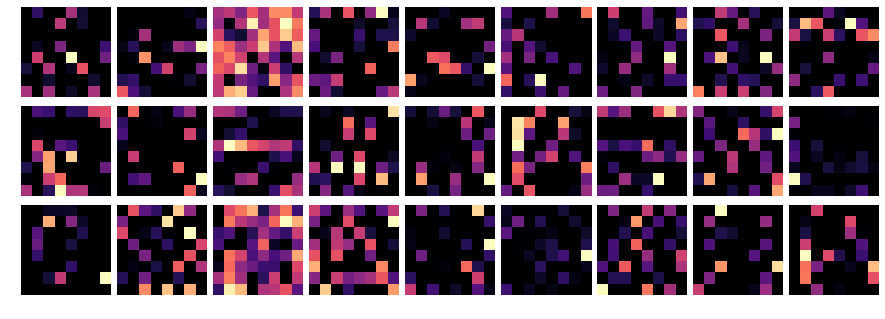

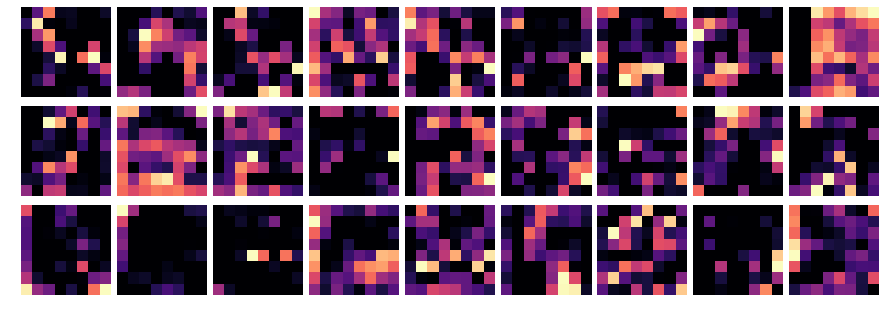

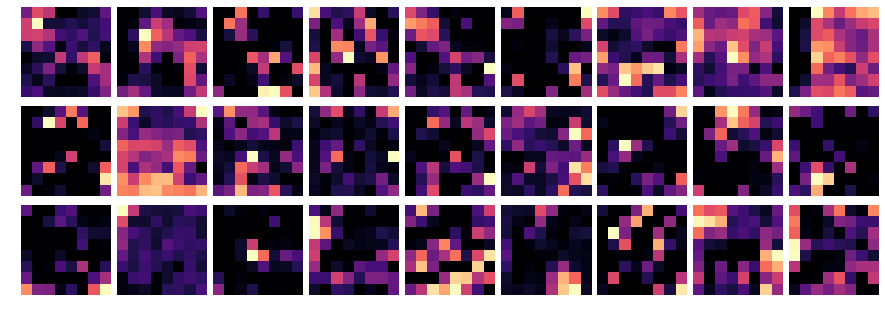

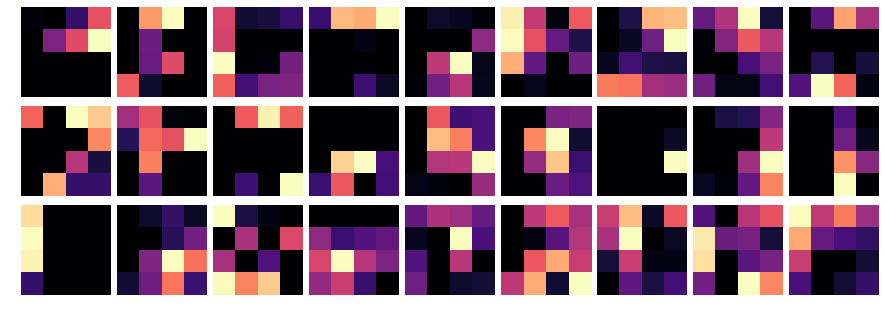

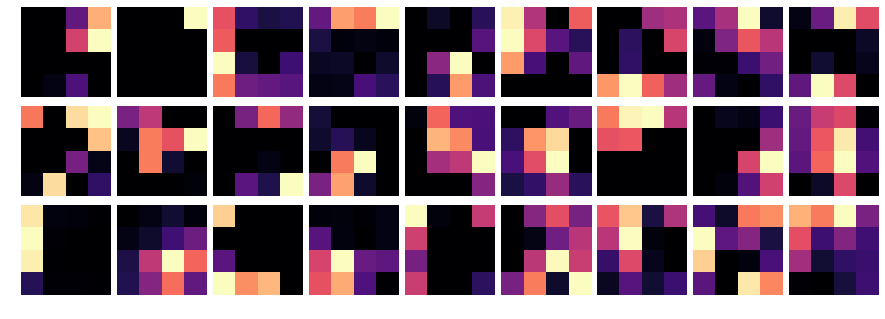

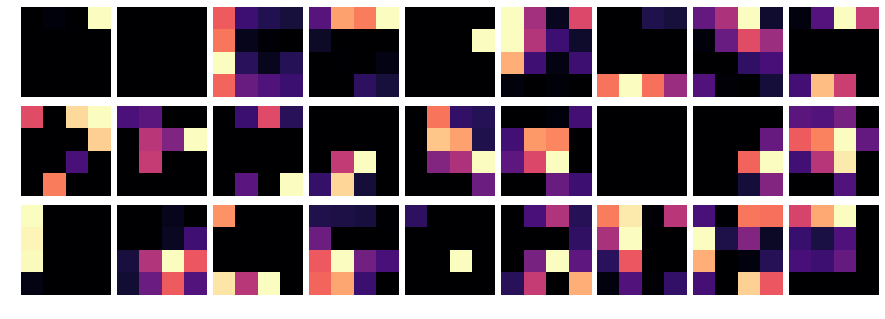

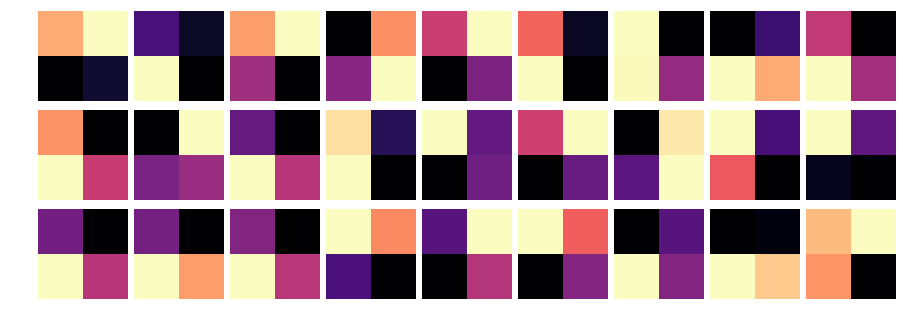

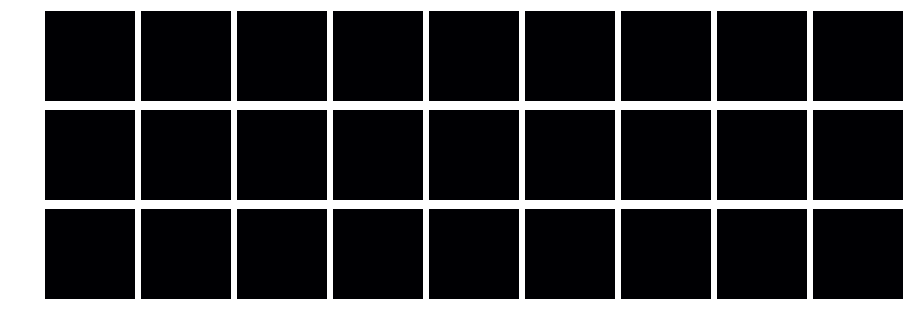

In [53]:
create_layer_vis(
    learn.model, path / "test/img2.jpg",
)

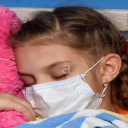

In [30]:
open_image(path / "test/img2.jpg").resize(128)

In [21]:
str(learn.predict(open_image(path / "test/img2.jpg"))[0])

'asleep'

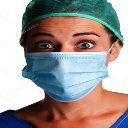

In [35]:
open_image(path / "test/img4.jpg").resize(128)

In [36]:
str(learn.predict(open_image(path / "test/img4.jpg"))[0])

'surprise'

# GRAD CAM

In [55]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

len(data.valid_ds) == len(losses) == len(idxs)

True

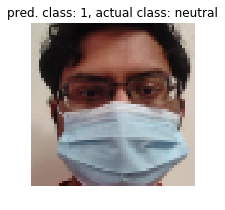

In [56]:
idx = 1
im, cl = learn.data.dl(DatasetType.Valid).dataset[idx]
cl = int(cl)
im.show(
    title=f"pred. class: {interp.pred_class[idx]}, actual class: {learn.data.classes[cl]}"
)

In [75]:
def GradCAM(idx:int,interp:ClassificationInterpretation, image = True):
    m = interp.learn.model.eval()
    im,cl = interp.learn.data.dl(DatasetType.Valid).dataset[idx]
    cl = int(cl)
    xb,_ = interp.data.one_item(im) #put into a minibatch of batch size = 1
    xb_im = Image(interp.data.denorm(xb)[0])
    xb = xb.cuda()
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cl)].backward() 
    acts  = hook_a.stored[0].cpu() #activation maps
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    mult = ((acts*grad_chan[...,None,None])).sum(0) #F.relu(((acts*grad_chan[...,None,None])).sum(0))
    if image:
        _,ax = plt.subplots()
        sz = list(xb_im.shape[-2:])
        xb_im.show(ax,title=f"pred. class: {interp.pred_class[idx]}, actual class: {learn.data.classes[cl]}")
        ax.imshow(mult, alpha=0.4, extent=(0,*sz[::-1],0),
              interpolation='bilinear', cmap='viridis')
    return mult

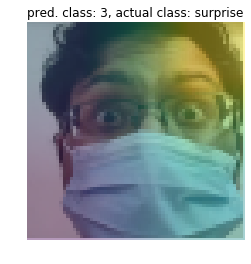

In [88]:
_ = GradCAM(np.random.randint(len(learn.data.valid_ds)),interp)
